In [1]:
import os
import glob
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import shutil
import random
import cv2

In [2]:
def remove_horizontal_lines(image_path):
    # Đọc ảnh gốc
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Không thể đọc ảnh tại: {image_path}")
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Bước 1: remove dòng kẻ ngoài vùng chữ viết
    thresh = cv2.adaptiveThreshold(
        gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 81, 17
    )
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (25, 1))
    remove_horizontal = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, horizontal_kernel, iterations=3)

    cnts = cv2.findContours(remove_horizontal, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    mask1 = np.zeros(gray.shape, np.uint8)
    for c in cnts:
        cv2.drawContours(mask1, [c], -1, (255, 255, 255), 2)

    img_dst = cv2.inpaint(img, mask1, 3, cv2.INPAINT_TELEA)

    # Bước 2: lọc dòng kẻ nhỏ bên trong nét chữ
    gray_dst = cv2.cvtColor(img_dst, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray_dst, 50, 150, apertureSize=3)
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 1))
    opening = cv2.morphologyEx(edges, cv2.MORPH_OPEN, horizontal_kernel)

    cnts = cv2.findContours(opening, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    mask2 = np.zeros(gray_dst.shape, np.uint8)
    for c in cnts:
        cv2.drawContours(mask2, [c], -1, (255, 255, 255), 2)

    img_cleaned = cv2.inpaint(img_dst, mask2, 3, cv2.INPAINT_TELEA)

    return img_cleaned

In [3]:

png_files = glob.glob("../thu_muc_gop_2/**/*.png", recursive=True)

for file in png_files:
    img = Image.open(file).convert('RGB')  # đảm bảo chuyển đúng kênh màu
    new_file = file.replace('.png', '.jpg')
    img.save(new_file, "JPEG")
    os.remove(file)
    


In [4]:
# files = glob.glob("data/ê/*.jpg")
# for i, file in enumerate(files):
#     os.rename(file, f'data/ê/{i+1}.jpg')

In [5]:

root_folder = '../thu_muc_gop_2'

class_folders = [f for f in os.listdir(root_folder) if os.path.isdir(os.path.join(root_folder, f))]

class_folders.sort()


for class_name in class_folders:
    class_path = os.path.join(root_folder, class_name)
    images = glob.glob(os.path.join(class_path, '*.jpg'))

    for image_path in images:
        try:
            img = Image.open(image_path).convert("RGB")
            img_resized = img.resize((50, 150))  
            img_resized.save(image_path, "JPEG")
        except Exception as e:
            print(f"Lỗi khi xử lý {image_path}: {e}")

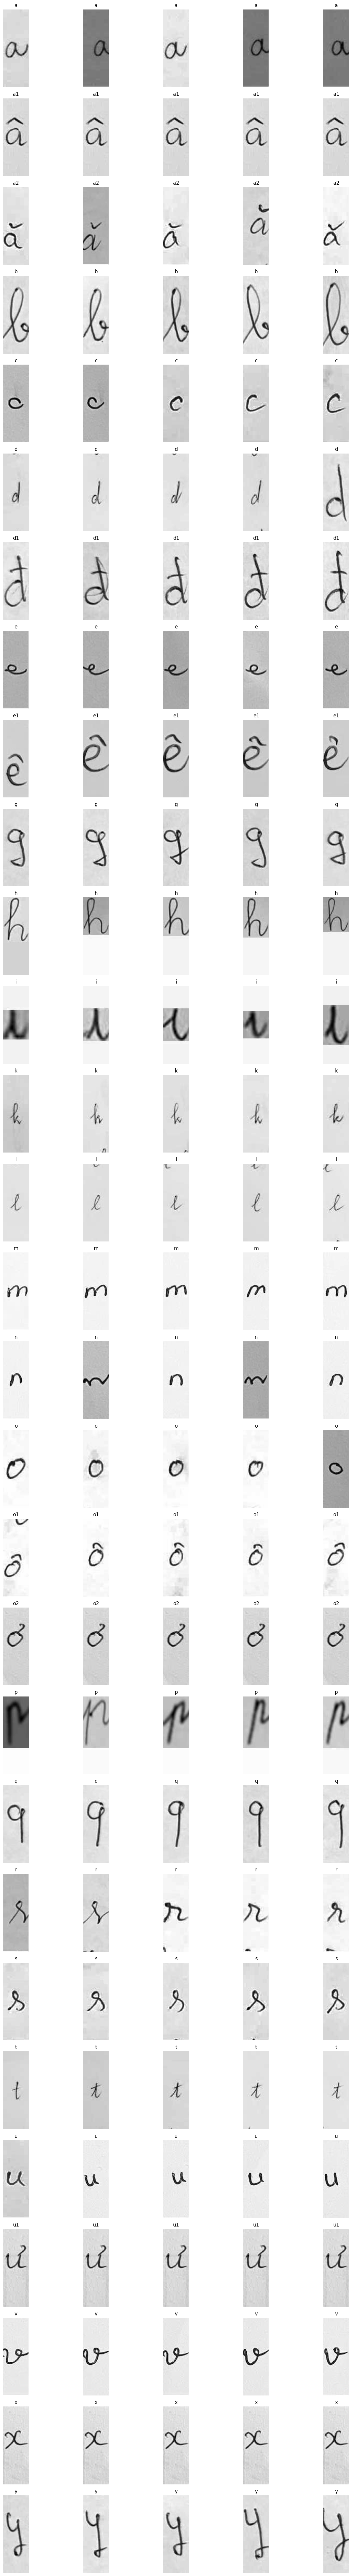

In [6]:
n_cols = 5  
n_rows = len(class_folders)

fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 3 * n_rows))

for row, class_name in enumerate(class_folders):
    class_path = os.path.join(root_folder, class_name)
    images = glob.glob(os.path.join(class_path, '*.jpg'))[:n_cols]

    for col in range(n_cols):
        ax = axs[row][col] if n_rows > 1 else axs[col]

        if col < len(images):
            img_pil = Image.open(images[col]).convert("L")   
            # img_pil = remove_horizontal_lines(images[col])

            img = np.array(img_pil)
            ax.imshow(img, cmap='gray')

            ax.set_title(f"{class_name}")
            ax.axis('off')
        else:
            print(class_name)
            ax.axis('off') 
plt.tight_layout()
plt.show()

In [7]:
# Cấu hình
output_folder = 'preprocessed_data'
train_ratio = 0.8

if os.path.exists(output_folder):
    shutil.rmtree(output_folder)

for subset in ['train', 'test']:
    os.makedirs(os.path.join(output_folder, subset), exist_ok=True)

for class_name in class_folders:
    class_path = os.path.join(root_folder, class_name)
    images = glob.glob(os.path.join(class_path, '*.jpg'))

    # Shuffle ảnh và chia
    random.shuffle(images)
    split_index = int(len(images) * train_ratio)
    train_images = images[:split_index]
    test_images = images[split_index:]

    for subset_name, subset_images in [('train', train_images), ('test', test_images)]:
        subset_class_dir = os.path.join(output_folder, subset_name, class_name)
        os.makedirs(subset_class_dir, exist_ok=True)

        for image_path in subset_images:
            try:
                img = Image.open(image_path).convert("L")
                image_name = os.path.basename(image_path)
                new_path = os.path.join(subset_class_dir, image_name)
                img.save(new_path, "JPEG")
            except Exception as e:
                print(f"Lỗi khi xử lý {image_path}: {e}")
